In [22]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from ts2vec import TS2Vec


In [24]:
import load_dataset

In [25]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

In [26]:
from sklearn.metrics import accuracy_score

def evaluate(model, X_test, y_test, class_names):
    test_preds = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, test_preds)
    print(f"Accuracy: {accuracy:.4f}")

    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, labels=[0, 1, 4], digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [27]:
def load_files(files, labels, max_len=5000):
    data_arr = []
    final_labels = []
    
    for filepath, label in zip(files, labels):
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        # cdf = calculate_cdf(x)
        x = np.expand_dims(x, axis=1)

        data_arr.append(x)
        final_labels.append(label)
    
    return np.array(data_arr), np.array(final_labels)

In [28]:
def get_data(data_files):
    files = []
    labels = []

    for operator in data_files:
        files.extend(data_files[operator]['files'])
        labels.extend([data_files[operator]['label']]*len(data_files[operator]['files']))


    data, labels = load_files(files, labels)

    return data, labels

In [29]:
nexmark_dataset = load_dataset.load_nexmark_data(is_split=False)
nexmark_data, nexmark_labels = get_data(nexmark_dataset)

File ./nexmark_dataset/q2_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli.csv is empty.
File ./nexmark_dataset/q6_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli+292_filter_category_times_id_plus_seller_mod_duration_is_less_than_initialBid.csv is empty.


In [30]:
secure_sgx_dataset = load_dataset.load_secure_sgx_data(is_split=False)
secure_sgx_data, secure_sgx_labels = get_data(secure_sgx_dataset)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'new_model_5000_1024.pkl')

In [32]:
nexmark_embeddings = model.encode(nexmark_data, encoding_window='full_series')
secure_sgx_embeddings = model.encode(secure_sgx_data, encoding_window='full_series')

In [33]:
import joblib

In [34]:
rf_nexmark = joblib.load('rf_grid_nexmark.pkl')
rf_nexmark.best_params_
# evaluate(rf_nexmark, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 250}

Accuracy: 0.4864
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7318    0.8474    0.7854       380
           1     0.8007    0.6619    0.7247       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.5206    0.7582    0.6174       732
   macro avg     0.5108    0.5031    0.5034       732
weighted avg     0.7649    0.7582    0.7562       732

Confusion Matrix (Test):
[[322  58   0   0   0   0   0]
 [118 233   1   0   0   0   0]
 [  0   0  36  63 335   1  48]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Confusion Matrix (Test):
[[322  58   0   0   0   0   0]
 [118 233   1   0   0   0   0]
 [  0   0  36  63 335   1  48]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

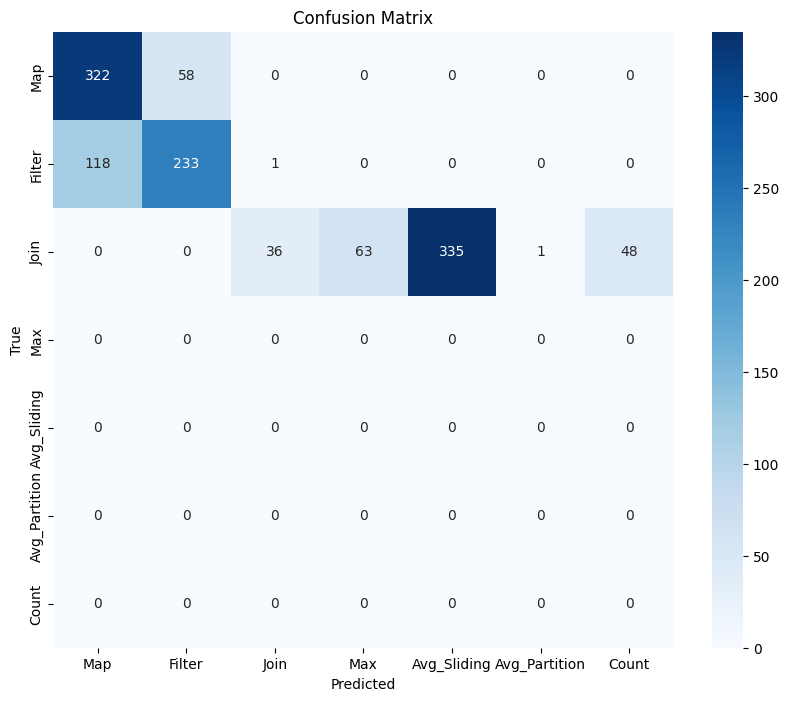

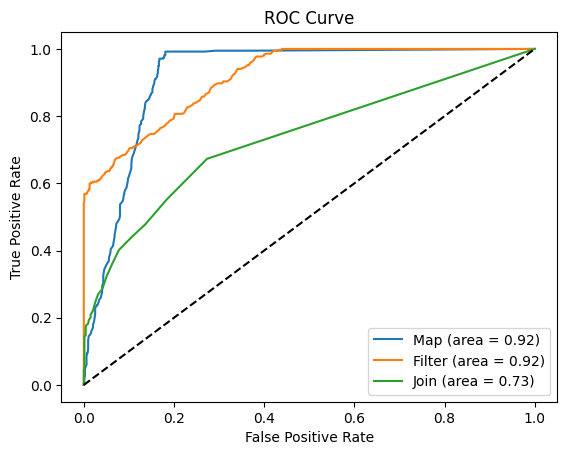

In [35]:
rf = RandomForestClassifier(**rf_nexmark.best_params_, n_jobs=-1, random_state=42)
rf.fit(nexmark_embeddings, nexmark_labels)
evaluate(rf, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

In [36]:
svr_nexmark = joblib.load('svr_grid_nexmark.pkl')
svr_nexmark.best_params_
# evaluate(svr_nexmark, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

{'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define pipeline: scaler + SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=100, gamma=1, kernel='rbf'))
])


# Fit the pipeline on the training data
# svr = SVC(**svr_nexmark.best_params_, probability=True, random_state=42)
# svr.fit(nexmark_data, nexmark_labels)
pipeline.fit(nexmark_embeddings, nexmark_labels)
evaluate(pipeline, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

Accuracy: 0.4255
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7115    0.4868    0.5781       380
           1     0.5856    0.7869    0.6715       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.4192    0.6311    0.5038       732
   macro avg     0.4324    0.4246    0.4165       732
weighted avg     0.6510    0.6311    0.6230       732

Confusion Matrix (Test):
[[185 195   0   0   0   0]
 [ 75 277   0   0   0   0]
 [  0   1  55  44 369  14]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [38]:
xgb_nexmark = joblib.load('xgb_grid_nexmark.pkl')
xgb_nexmark.best_params_
# evaluate(xgb_nexmark, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

{'gamma': 0, 'max_depth': 3, 'n_estimators': 150}

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4790
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7237    0.7237    0.7237       380
           1     0.7017    0.7017    0.7017       352
           4     0.0000    0.0000    0.0000         0

   micro avg     0.4939    0.7131    0.5836       732
   macro avg     0.4751    0.4751    0.4751       732
weighted avg     0.7131    0.7131    0.7131       732

Confusion Matrix (Test):
[[275 105   0   0   0   0]
 [105 247   0   0   0   0]
 [  0   0  60  53 325  45]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
Confusion Matrix (Test):
[[275 105   0   0   0   0]
 [105 247   0   0   0   0]
 [  0   0  60  53 325  45]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

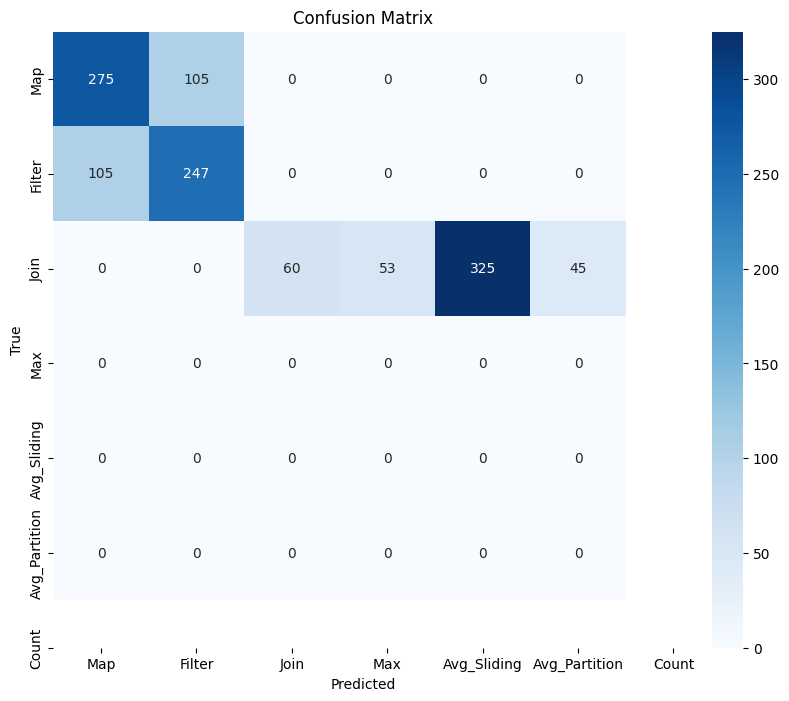

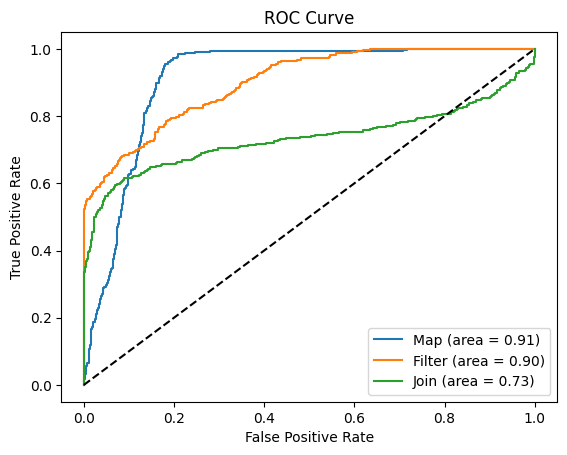

In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_nexmark.best_params_, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(nexmark_embeddings, nexmark_labels)
evaluate(xgb, secure_sgx_embeddings, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

In [21]:
def extract_transformer_embeddings(dataset, model):
    # Embedding extraction
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(len(dataset)):
            ts = dataset[i]
            ts_tensor = torch.tensor(ts).float().unsqueeze(0).unsqueeze(-1).to(device)
            mask = torch.zeros(1, ts_tensor.size(1), dtype=torch.bool).to(device)
            z = model(ts_tensor, src_key_padding_mask=mask)
            embeddings.append(z.cpu().numpy())
    return np.vstack(embeddings)

In [ ]:
transformer_model = joblib.load('transformer_model.pkl')